<h1> Libraries</h1>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
import os
import random
import tensorflow as tf
import torch
# Set seeds for reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# PyTorch CPU & GPU
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Make CuDNN deterministic
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

<h1> Data</h1>

In [3]:
path = Path.home() / "OneDrive - Université De Technologie De Belfort-Montbeliard" / "UTBM" / "Data" / "PM200 fuel cell aging data"
df1 = pd.read_excel(path / 'Data.xlsx', sheet_name="Case 1 - stationary prime power", skiprows=1)
df1=df1.sort_values("Operating hours (h)") # sort the data

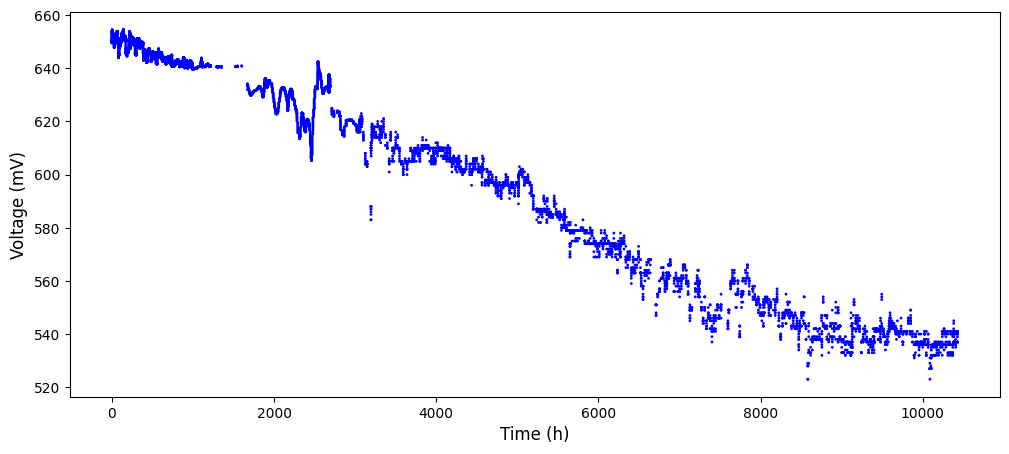

In [4]:
plt.figure(figsize=(12, 5))
plt.scatter(df1['Operating hours (h)'], df1['mean cell voltage (mv)'],facecolors='none', edgecolors='blue', s=1, label='Experimental data')
plt.xlabel("Time (h)", fontsize=12)
plt.ylabel("Voltage (mV)", fontsize=12)
plt.show()

<h2> Uniform simpling</h2>

In [5]:
def interpolation (df):
    df["T(h)"]=np.linspace(df["Operating hours (h)"].min(), df["Operating hours (h)"].max(), len(df))
    df["U(mV)"] = np.interp(df["T(h)"], df["Operating hours (h)"],df["mean cell voltage (mv)"])
    df.drop(["Operating hours (h)","mean cell voltage (mv)"], axis=1, inplace=True)
    return df

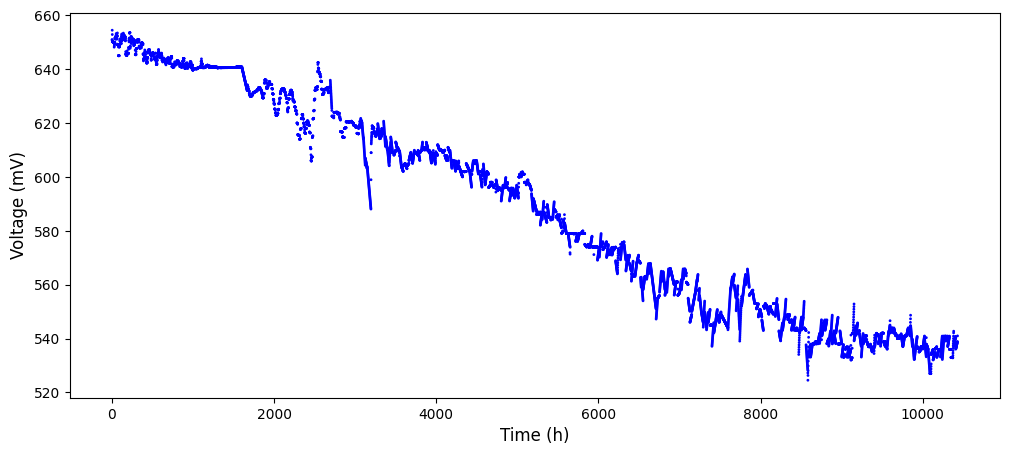

In [6]:
df= interpolation(df1)
plt.figure(figsize=(12, 5))
plt.scatter(df['T(h)'], df['U(mV)'],facecolors='none', edgecolors='blue', s=1, label='Experimental data')
plt.xlabel("Time (h)", fontsize=12)
plt.ylabel("Voltage (mV)", fontsize=12)
plt.show()

<h2> Sliding window</h2>

In [7]:
Wsize = 24
df = df.assign(MeanVoltage=df['U(mV)'].rolling(window=Wsize,center=True ,min_periods=2).mean().array)
print (df1["T(h)"].diff()[1]*Wsize)

23.545845719661337


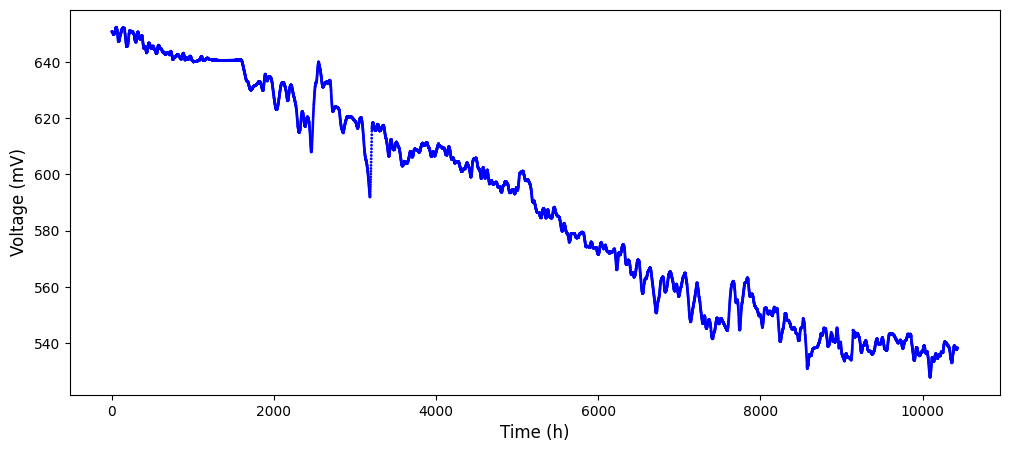

In [8]:
plt.figure(figsize=(12, 5))
plt.scatter(df1['T(h)'], df['MeanVoltage'],facecolors='none', edgecolors='blue', s=1, label='Experimental data')
plt.xlabel("Time (h)", fontsize=12)
plt.ylabel("Voltage (mV)", fontsize=12)
plt.show()

<h2> Create shifted columns</h2>

In [9]:
def Data_shift(df, n_past=0, n_future=0):

    base = df["MeanVoltage"]

    # past: U-n ... U-1
    past_cols = [
        base.shift(i).rename(f"U-{i}")
        for i in range(n_past, 0, -1)
    ]

    # present: U
    present_col = [base.rename("U")]

    # future: U+1 ... U+n
    future_cols = [
        base.shift(-i).rename(f"U+{i}")
        for i in range(1, n_future + 1)
    ]

    # concatenate ONCE
    new_df = pd.concat(past_cols + present_col + future_cols, axis=1)

    # drop NaNs caused by shifting
    new_df = new_df.dropna().reset_index(drop=True)

    return new_df

In [10]:
Past_days=3
Future_days=1
n_past=int(Past_days*24/df["T(h)"].diff()[1])
n_future=int(Future_days*24/df["T(h)"].diff()[1])
DF = Data_shift (df,n_past, n_future)
DF

,U-73,U-72,U-71,U-70,U-69,U-68,U-67,U-66,U-65,U-64,...,U+15,U+16,U+17,U+18,U+19,U+20,U+21,U+22,U+23,U+24
0,650.848344,650.789462,650.738101,650.692759,650.652305,650.615878,650.582806,650.552560,650.524716,650.498930,...,647.451535,647.469273,647.488849,647.510264,647.533517,647.581251,647.763695,647.946782,648.130514,648.314889
1,650.789462,650.738101,650.692759,650.652305,650.615878,650.582806,650.552560,650.524716,650.498930,650.474922,...,647.469273,647.488849,647.510264,647.533517,647.581251,647.763695,647.946782,648.130514,648.314889,648.499907
2,650.738101,650.692759,650.652305,650.615878,650.582806,650.552560,650.524716,650.498930,650.474922,650.452460,...,647.488849,647.510264,647.533517,647.581251,647.763695,647.946782,648.130514,648.314889,648.499907,648.685569
3,650.692759,650.652305,650.615878,650.582806,650.552560,650.524716,650.498930,650.474922,650.452460,650.431351,...,647.510264,647.533517,647.581251,647.763695,647.946782,648.130514,648.314889,648.499907,648.685569,648.871874
4,650.652305,650.615878,650.582806,650.552560,650.524716,650.498930,650.474922,650.452460,650.431351,650.386908,...,647.533517,647.581251,647.763695,647.946782,648.130514,648.314889,648.499907,648.685569,648.871874,649.058824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10529,538.087069,537.970680,537.846931,537.715824,537.577357,537.431532,537.278347,537.117803,536.824901,536.524639,...,537.816896,537.743726,537.751041,537.652565,537.722720,537.793246,537.864201,537.935650,538.007678,538.080385
10530,537.970680,537.846931,537.715824,537.577357,537.431532,537.278347,537.117803,536.824901,536.524639,536.217018,...,537.743726,537.751041,537.652565,537.722720,537.793246,537.864201,537.935650,538.007678,538.080385,538.153899
10531,537.846931,537.715824,537.577357,537.431532,537.278347,537.117803,536.824901,536.524639,536.217018,535.902037,...,537.751041,537.652565,537.722720,537.793246,537.864201,537.935650,538.007678,538.080385,538.153899,538.228381
10532,537.715824,537.577357,537.431532,537.278347,537.117803,536.824901,536.524639,536.217018,535.902037,535.579698,...,537.652565,537.722720,537.793246,537.864201,537.935650,538.007678,538.080385,538.153899,538.228381,538.304040


<h2> Normalization</h2>

In [11]:
Trate = 0.7

Train = DF.iloc[0:int(len(DF)*Trate)]

Test = DF.iloc[int(len(DF)*Trate):]

print(len(Train), len(Test))

X_tr = Train [Train.columns [:n_past+1]].values
Y_tr = Train [Train.columns [-n_future:]].values

X_ts = Test [Test.columns [:n_past+1]].values
Y_ts = Test [Test.columns [-n_future:]].values

7373 3161


In [12]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_tr_scaled = scaler_x.fit_transform(X_tr)
X_ts_scaled = scaler_x.transform(X_ts)

Y_tr_scaled = scaler_y.fit_transform(Y_tr)
Y_ts_scaled = scaler_y.transform(Y_ts)

Xtr = X_tr_scaled.reshape(X_tr_scaled.shape[0], n_past+1, 1)
Xts= X_ts_scaled.reshape(X_ts_scaled.shape[0], n_past+1, 1)
Ytr = Y_tr_scaled.reshape(Y_tr_scaled.shape[0], n_future, 1)
Yts= Y_ts_scaled.reshape(Y_ts_scaled.shape[0], n_future, 1)
print ("Xtr trainX shape is:",np.shape(Xtr))
print ("Ytr trainX shape is:",np.shape(Ytr))
print ("Xts trainX shape is:",np.shape(Xts))
print ("Yts trainX shape is:",np.shape(Yts))

Xtr trainX shape is: (7373, 74, 1)
Ytr trainX shape is: (7373, 24, 1)
Xts trainX shape is: (3161, 74, 1)
Yts trainX shape is: (3161, 24, 1)


In [13]:
import torch
import torch.nn as nn

class CNN_LSTM_MultiHorizon(nn.Module):
    def __init__(self, input_dim=1, hidden=64, out_len=n_future, dropout=0.1):
        super().__init__()
        self.out_len = out_len

        # LSTM encoder
        self.lstm1 = nn.LSTM(input_size=input_dim, hidden_size=hidden, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=hidden, hidden_size=hidden, batch_first=True)



        # ----- Step 2: Multi-head self-attention -----
        # PyTorch MHA uses "embed_dim" = num_heads * head_dim
        embed_dim = 64  # 32*8
        self.attention_proj = nn.Linear(input_dim, embed_dim)
        self.mha = nn.MultiheadAttention( embed_dim=embed_dim, num_heads=4, dropout=0, batch_first=True)

        self.post_cat_dim = hidden + embed_dim  # CNN(64) + LSTM(hidden)

        # Use last timestep (more stable than mean pooling for forecasting)
        self.fc1 = nn.Linear(self.post_cat_dim, 32)
        self.dropout = nn.Dropout(dropout)

        # output all horizons at once (24 values)
        self.fc_out = nn.Linear(32, out_len)

    def forward(self, x):
        # x: (B, seq_len, input_dim)

        # Transformer branch
        attn_input = self.attention_proj(x)  # (B, L, 192)
        attn_output, _ = self.mha(attn_input, attn_input, attn_input)

        # LSTM branch
        x_lstm, _ = self.lstm1(x)                  # (B, seq_len, hidden)
        x_lstm, _ = self.lstm2(x_lstm)             # (B, seq_len, hidden)

        # concat features per timestep
        x_cat = torch.cat([x_lstm, attn_output], dim=-1) # (B, seq_len, 64+hidden)

        # take last timestep as context
        h = x_cat[:, -1, :]                        # (B, 64+hidden)

        h = torch.relu(self.fc1(h))
        h = self.dropout(h)

        y = self.fc_out(h)                         # (B, out_len)

        return y.unsqueeze(-1)  

In [14]:
seq_len  = Xtr.shape[1]
input_dim = Xtr.shape[2]

model = CNN_LSTM_MultiHorizon(input_dim=input_dim)
print(model)

from torchinfo import summary
summary(model, input_size=(1, seq_len, input_dim))

CNN_LSTM_MultiHorizon(
  (lstm1): LSTM(1, 64, batch_first=True)
  (lstm2): LSTM(64, 64, batch_first=True)
  (attention_proj): Linear(in_features=1, out_features=64, bias=True)
  (mha): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
  (fc1): Linear(in_features=128, out_features=32, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc_out): Linear(in_features=32, out_features=24, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
CNN_LSTM_MultiHorizon                    [1, 24, 1]                --
├─Linear: 1-1                            [1, 74, 64]               128
├─MultiheadAttention: 1-2                [1, 74, 64]               16,640
├─LSTM: 1-3                              [1, 74, 64]               17,152
├─LSTM: 1-4                              [1, 74, 64]               33,280
├─Linear: 1-5                            [1, 32]                   4,128
├─Dropout: 1-6                           [1, 32]                   --
├─Linear: 1-7                            [1, 24]                   792
Total params: 72,120
Trainable params: 72,120
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 3.74
Input size (MB): 0.00
Forward/backward pass size (MB): 0.11
Params size (MB): 0.22
Estimated Total Size (MB): 0.34

In [15]:
from torch.utils.data import TensorDataset, DataLoader
Xtr_torch = torch.tensor(Xtr, dtype=torch.float32)
Ytr_torch = torch.tensor(Ytr, dtype=torch.float32)

Xts_torch = torch.tensor(Xts, dtype=torch.float32)
Yts_torch = torch.tensor(Yts, dtype=torch.float32)

# Create datasets
train_dataset = TensorDataset(Xtr_torch, Ytr_torch)
test_dataset  = TensorDataset(Xts_torch, Yts_torch)

BATCH_SIZE= 32
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

In [16]:
criterion = torch.nn.MSELoss()  # MAE
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# LR scheduler equivalent to ReduceLROnPlateau
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=5,
    min_lr=1e-6
)

In [17]:
device = torch.device("cuda")
model.to(device)

EPOCHS = 100
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # ---- Validation -----
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for Xv, yv in test_loader:
            Xv = Xv.to(device)
            yv = yv.to(device)

            pv = model(Xv)
            lv = criterion(pv, yv)

            val_loss += lv.item()

    val_loss /= len(test_loader)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS} — train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")

Epoch 1/100 — train_loss=0.2205 | val_loss=0.1455
Epoch 2/100 — train_loss=0.0724 | val_loss=0.0845
Epoch 3/100 — train_loss=0.0546 | val_loss=0.0768
Epoch 4/100 — train_loss=0.0452 | val_loss=0.0551
Epoch 5/100 — train_loss=0.0393 | val_loss=0.0464
Epoch 6/100 — train_loss=0.0383 | val_loss=0.0404
Epoch 7/100 — train_loss=0.0372 | val_loss=0.0511
Epoch 8/100 — train_loss=0.0358 | val_loss=0.0250
Epoch 9/100 — train_loss=0.0308 | val_loss=0.0141
Epoch 10/100 — train_loss=0.0323 | val_loss=0.0227
Epoch 11/100 — train_loss=0.0309 | val_loss=0.0204
Epoch 12/100 — train_loss=0.0304 | val_loss=0.0265
Epoch 13/100 — train_loss=0.0294 | val_loss=0.0205
Epoch 14/100 — train_loss=0.0264 | val_loss=0.0096
Epoch 15/100 — train_loss=0.0260 | val_loss=0.0239
Epoch 16/100 — train_loss=0.0241 | val_loss=0.0107
Epoch 17/100 — train_loss=0.0263 | val_loss=0.0122
Epoch 18/100 — train_loss=0.0233 | val_loss=0.0079
Epoch 19/100 — train_loss=0.0225 | val_loss=0.0073
Epoch 20/100 — train_loss=0.0217 | val_l

<h2> One-Step Ahead</h2>

In [18]:
def plot_pytorch(df, ln_tr, N_past, pred_train, pred_test, name="LSTM_CNN", save_name="name", title="title"):

    # ----- Plot -----
    plt.figure(figsize=(12, 5))

    # Experimental data
    plt.scatter(df['T(h)'], df['MeanVoltage'], facecolors='none', edgecolors='blue', s=1, label='Preprocessed signal')

    # Train predictions
    plt.plot( df[N_past+1:ln_tr+N_past+1]['T(h)'], pred_train, color='red', linestyle='--', label=name + ' (Train)')

    # Test predictions
    plt.plot( df[ln_tr+N_past+1:]['T(h)'], pred_test, color='green', label=name + ' (Test)')

    # Mark training region
    split_time = df['T(h)'].iloc[ln_tr + N_past+1]
    plt.axvspan(df['T(h)'].iloc[0], split_time, color='gray', alpha=0.1, label='Training region')

    plt.xlabel("Time (h)", fontsize=12)
    plt.ylabel("Voltage (V)", fontsize=12)
    plt.title("Fuel Cell Voltage Degradation – " + title, fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
#    plt.savefig(save_name + ".pdf", format='pdf', bbox_inches='tight')
    plt.show()

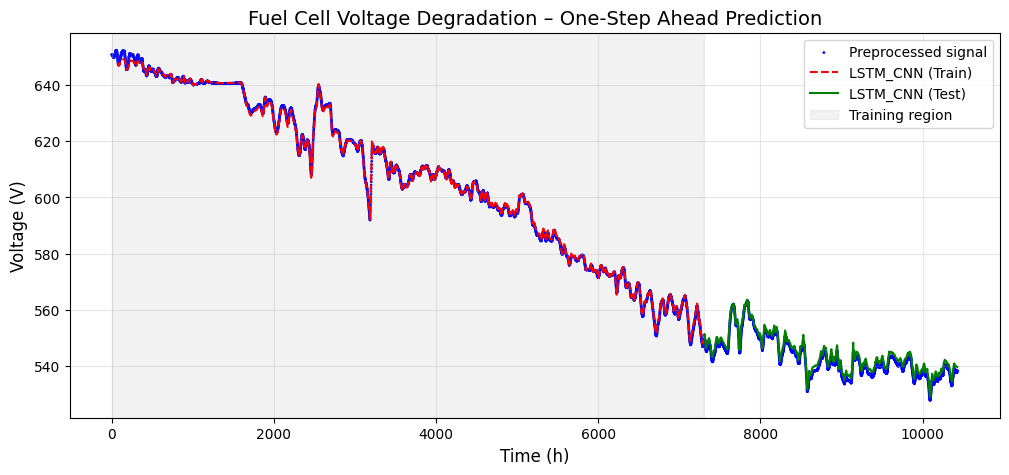

In [19]:
device = torch.device("cpu")
model = model.to(device)
model.eval()
Xtrain_torch = torch.tensor(Xtr, dtype=torch.float32).to(device)
Xtest_torch = torch.tensor(Xts, dtype=torch.float32).to(device)

with torch.no_grad():
    pred_train = model(Xtrain_torch).cpu().numpy()
    pred_test = model(Xtest_torch).cpu().numpy()
pred_train = scaler_y.inverse_transform(pred_train.squeeze(-1))
pred_test = scaler_y.inverse_transform(pred_test.squeeze(-1))
pred_test =  np.concatenate([pred_test[:-1,0], pred_test[-1, 0:]])

plot_pytorch( df, len(Xtr), n_past, pred_train[:,0], pred_test, name="LSTM_CNN", save_name="PM200_1_LSTM_CNN_1step",
              title="One-Step Ahead Prediction")

<h2> 1-Day Ahead</h2>

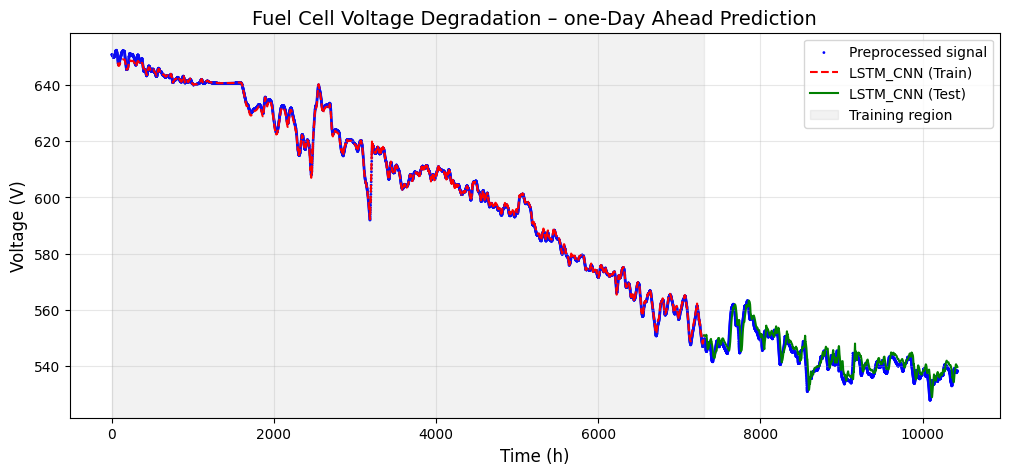

In [20]:
device = torch.device("cpu")
model = model.to(device)
model.eval()

with torch.no_grad():

    OnedayPred = model(Xtest_torch).cpu().numpy()

OnedayPred = scaler_y.inverse_transform(OnedayPred.squeeze(-1))
OnedayPred = np.concatenate([OnedayPred[0], OnedayPred[1:,-1]])

plot_pytorch( df, len(Xtr), n_past, pred_train[:,0], OnedayPred, name="LSTM_CNN", save_name="PM200_1_LSTM_CNN_1step",
              title="one-Day Ahead Prediction")

<h2> 2-Day Ahead</h2>

In [21]:
def TwodayPred_pt(model, First_Xtest, Y_unscaled, scaler_x, scaler_y, device="cpu"):
    model.eval()
    model = model.to(device)
    
    x_input = First_Xtest.copy().reshape(1, First_Xtest.shape[0], First_Xtest.shape[1])
    preds_unscaled = []
    
    for i in range(len(Y_unscaled)-23):
        # predict for the defined time
        xt = torch.tensor(x_input, dtype=torch.float32).to(device)
        with torch.no_grad():
            yhat_scaled = model(xt).cpu().numpy()
        yhat_unscaled = scaler_y.inverse_transform(yhat_scaled.squeeze(-1))
        if i<2 :
            preds_unscaled.append(yhat_unscaled[0])
        else :
            preds_unscaled.append(yhat_unscaled[0,-1])
        
        # unscale the input data before appending
        x_input = scaler_x.inverse_transform(np.squeeze(x_input, axis=-1))

        
        # Slide the window forward (drop first, append true), scale and reshape
        if i<2:
            x_input = np.expand_dims(scaler_x.transform(np.concatenate([x_input[:, 24:], yhat_unscaled], axis=1)), axis=-1)
        else :
            x_input[0][24]=Y_unscaled[i-2,0]
            x_input = np.expand_dims(scaler_x.transform(np.concatenate([x_input[:, 1:], [[Y_unscaled[i,0]]]], axis=1)), axis=-1)
        
        
    return preds_unscaled

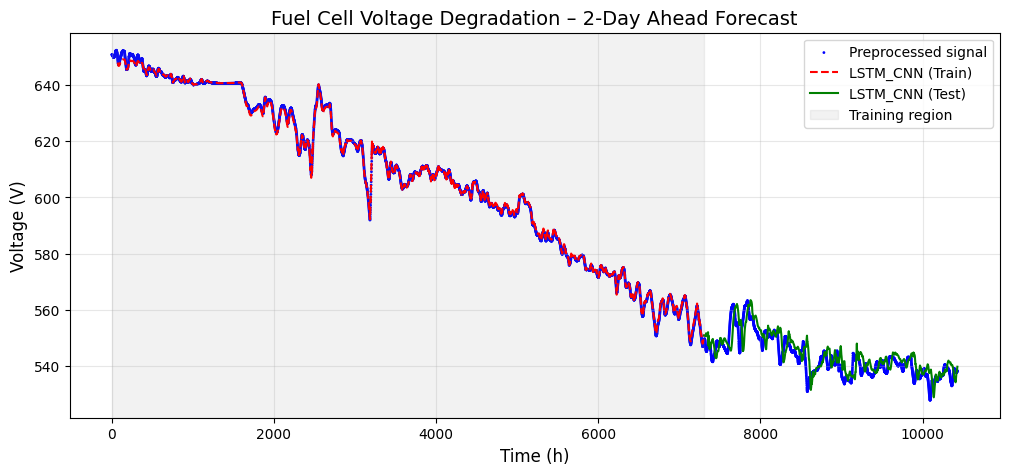

In [22]:
TwodayPred = TwodayPred_pt(model, Xts[0], scaler_y.inverse_transform(Yts.squeeze(-1)), scaler_x, scaler_y)
TwodayPred = np.concatenate([np.atleast_1d(x) for x in TwodayPred])
plot_pytorch(df, len(Xtr), n_past, pred_train[:,0], TwodayPred, name="LSTM_CNN", save_name="PM200_1_LSTM_CNN_2day",
              title="2-Day Ahead Forecast")

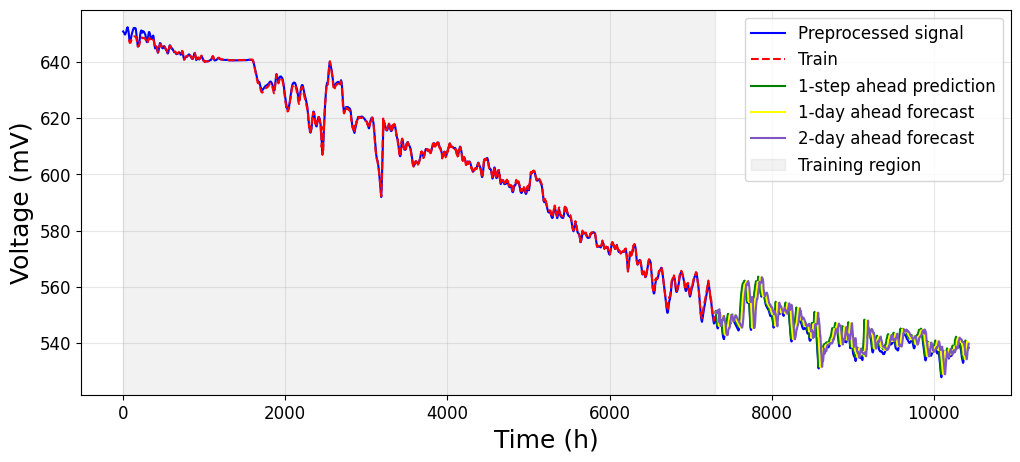

In [23]:
# ----- Plot -----
plt.figure(figsize=(12, 5))
plt.style.use("default")
# Experimental data

plt.plot(df['T(h)'], df['MeanVoltage'], color='blue', label='Preprocessed signal')

# Train predictions
plt.plot( df[n_past+1:len(Xtr)+n_past+1]['T(h)'], pred_train[:,0], color='red', linestyle='--', label='Train')

# Test predictions 
plt.plot( df[len(Xtr)+n_past+1:]['T(h)'], pred_test, color='green', label= '1-step ahead prediction')
plt.plot( df[len(Xtr)+n_past+1:]['T(h)'], OnedayPred, color='yellow', label= '1-day ahead forecast')
plt.plot( df[len(Xtr)+n_past+1:]['T(h)'], TwodayPred, color="#7E57C2", label= '2-day ahead forecast')


# Mark training region
split_time = df['T(h)'].iloc[len(Xtr) + n_past]
plt.axvspan(df['T(h)'].iloc[0], split_time, color='gray', alpha=0.1, label='Training region')

plt.xlabel("Time (h)", fontsize=18)
plt.ylabel("Voltage (mV)", fontsize=18)
#plt.title("Fuel Cell Voltage Prediction", fontsize=14)
plt.tick_params(axis='both', colors='black', labelsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
#plt.savefig("PM200_1_LSTMATTn.pdf", format='pdf', bbox_inches='tight')
#plt.savefig("PM200_1_LSTMATTn.png", dpi=600, bbox_inches="tight", facecolor="white")
plt.show()

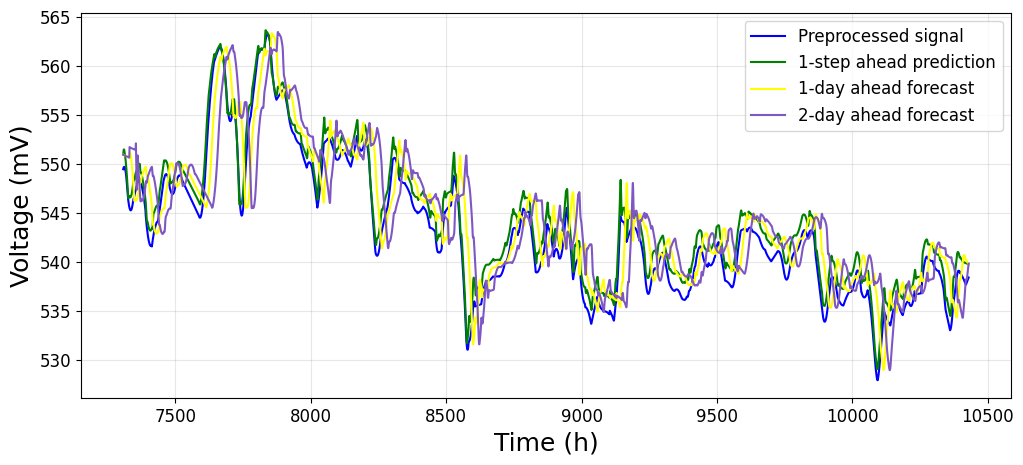

In [24]:
# ----- Plot -----
plt.figure(figsize=(12, 5))
plt.style.use("default")
# Experimental data

plt.plot(df[len(Xtr)+n_past+1:]['T(h)'], df[len(Xtr)+n_past+1:]['MeanVoltage'], color='blue', label='Preprocessed signal')

# Test predictions 
plt.plot( df[len(Xtr)+n_past+1:]['T(h)'], pred_test, color='green', label= '1-step ahead prediction')
plt.plot( df[len(Xtr)+n_past+1:]['T(h)'], OnedayPred, color='yellow', label= '1-day ahead forecast')
plt.plot( df[len(Xtr)+n_past+1:]['T(h)'], TwodayPred, color="#7E57C2", label= '2-day ahead forecast')




plt.xlabel("Time (h)", fontsize=18)
plt.ylabel("Voltage (mV)", fontsize=18)
#plt.title("Fuel Cell Voltage Prediction", fontsize=14)
plt.tick_params(axis='both', colors='black', labelsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
#plt.savefig("PM200_1_LSTMATTn_pred.pdf", format='pdf', bbox_inches='tight')
#plt.savefig("PM200_1_LSTMATTn_pred.png", dpi=600, bbox_inches="tight", facecolor="white")
plt.show()

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def regression_metrics(y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return mse, rmse, mae, r2

y_train_true = df[n_past+1:len(Xtr)+n_past+1]['MeanVoltage']   # or whatever your true training target is
y_train_pred = pred_train[:, 0]

mse_tr, rmse_tr, mae_tr, r2_tr = regression_metrics(y_train_true, y_train_pred)

print("TRAINING METRICS")
print(f"MSE  : {mse_tr:.4f}")
print(f"RMSE : {rmse_tr:.4f}")
print(f"MAE  : {mae_tr:.4f}")
print(f"R²   : {r2_tr:.4f}")

TRAINING METRICS
MSE  : 0.4094
RMSE : 0.6398
MAE  : 0.4475
R²   : 0.9995


In [26]:
y_test_true = df[len(Xtr) + n_past + 1:]['MeanVoltage']
mse_1, rmse_1, mae_1, r2_1 = regression_metrics(y_test_true, pred_test)

print("\n1-STEP AHEAD")
print(f"MSE  : {mse_1:.4f}")
print(f"RMSE : {rmse_1:.4f}")
print(f"MAE  : {mae_1:.4f}")
print(f"R²   : {r2_1:.4f}")


mse_1d, rmse_1d, mae_1d, r2_1d = regression_metrics(y_test_true, OnedayPred)

print("\n1-DAY AHEAD")
print(f"MSE  : {mse_1d:.4f}")
print(f"RMSE : {rmse_1d:.4f}")
print(f"MAE  : {mae_1d:.4f}")
print(f"R²   : {r2_1d:.4f}")


mse_2d, rmse_2d, mae_2d, r2_2d = regression_metrics(y_test_true, TwodayPred)

print("\n2-DAY AHEAD")
print(f"MSE  : {mse_2d:.4f}")
print(f"RMSE : {rmse_2d:.4f}")
print(f"MAE  : {mae_2d:.4f}")
print(f"R²   : {r2_2d:.4f}")


1-STEP AHEAD
MSE  : 2.3925
RMSE : 1.5468
MAE  : 1.4725
R²   : 0.9496

1-DAY AHEAD
MSE  : 9.6562
RMSE : 3.1074
MAE  : 2.3869
R²   : 0.7966

2-DAY AHEAD
MSE  : 19.9766
RMSE : 4.4695
MAE  : 3.4161
R²   : 0.5792
